# Pneumonia Prediction in Chest X-rays

* I'm working on a Pneumonia Detection Project using Chest X-rays. In this project, I'm building a model that predicts whether a chest X-ray image shows signs of pneumonia.

* This is a binary classification problem, determining whether a chest X-ray is classified as "Normal" or "Pneumonia." Given the medical implications of this project, accuracy is paramount. While a false positive (classifying a normal X-ray as pneumonia) is less desirable, a false negative (classifying a pneumonia case as normal) is completely unacceptable.


So by keeping all this information in mind let's start wroking on it.

The opendatasets library is a Python library designed to simplify the process of downloading datasets from various online sources like Kaggle and Google Drive1
. It allows you to download datasets with a single Python command

In [ ]:
!pip install opendatasets

downloading the Dataset from Kaggle URL using opendatasets "download" helper function.

To download the dataset we need to provide kaggle account Username and the API key.

In [ ]:
import opendatasets as od
path = "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia"
od.download(path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: siddeshparkar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [01:51<00:00, 22.2MB/s]


# The structure of the downloaded dataset is as follows:
* The main directory, "chest_xray," contains three subdirectories: "train," "test," and "val."
* Each of these subdirectories further contains two subdirectories: "NORMAL" and "PNEUMONIA."
* The "NORMAL" directory contains all chest X-ray images that are normal, while the "PNEUMONIA" directory contains images that show signs of pneumonia.

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
import os

# Define directories for the dataset
base_dir = 'chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

<h3>load image data from directories and generate batches of preprocessed and augmented images.</h3>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing settings
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Image Data Generators for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Validation set normalization

test_datagen = ImageDataGenerator(rescale=1./255)  # Test set normalization

In [ ]:
# Load the data and apply transformations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Since this is a binary classification problem (NORMAL vs PNEUMONIA)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Let's visualize the Images and take a look at the imagery data we are going to work on!

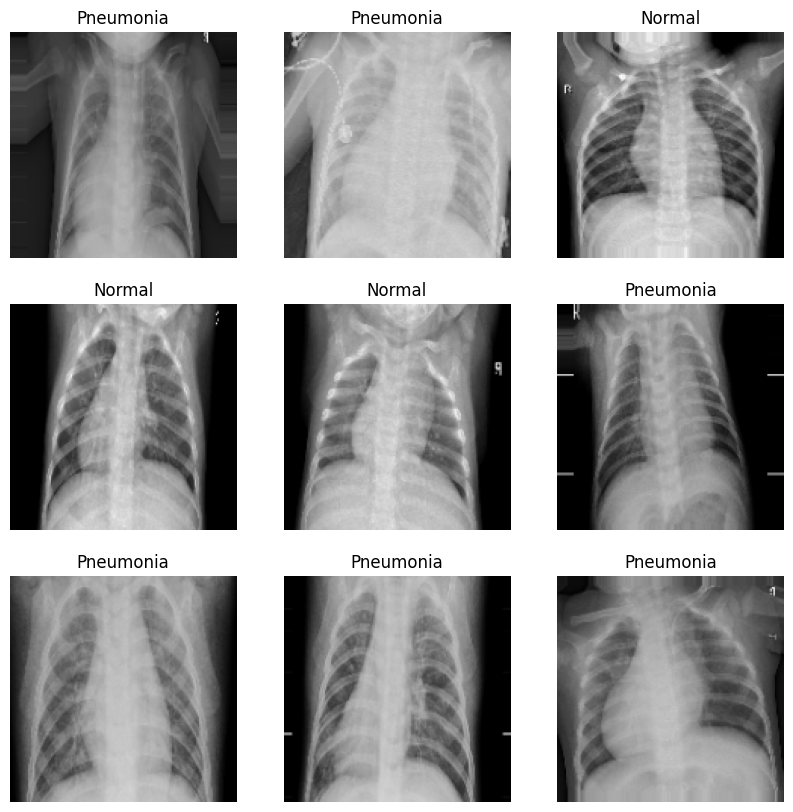

Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
import matplotlib.pyplot as plt

# Visualize a few samples from the training set
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        plt.title("Pneumonia" if labels[i] else "Normal")
        plt.axis('off')
    plt.show()

plot_images(train_generator)

# Get class indices to map labels
print(f"Class labels: {train_generator.class_indices}")

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

# Function to create datasets
def create_dataset(directory, batch_size, img_size, shuffle=True):
    return image_dataset_from_directory(
        directory,
        shuffle=shuffle,
        batch_size=batch_size,
        image_size=img_size
    )

# Create train, validation, and test datasets
train_dataset = create_dataset(train_dir, BATCH_SIZE, IMG_SIZE)
val_dataset = create_dataset(val_dir, BATCH_SIZE, IMG_SIZE, shuffle=False)
test_dataset = create_dataset(test_dir, BATCH_SIZE, IMG_SIZE, shuffle=False)

class_names = train_dataset.class_names

# Prefetching: optimizing dataset loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
import tensorflow as tf
import os

num_classes = len(class_names)

# Get input image shape (width, height, channels)
for image_batch, label_batch in train_dataset.take(1):
    input_shape = image_batch.shape[1:]  # Skip batch dimension

# Count the total number of images in each dataset
def dataset_size(dataset):
    return sum(1 for _ in dataset)

train_size = dataset_size(train_dataset) * BATCH_SIZE
val_size = dataset_size(val_dataset) * BATCH_SIZE
test_size = dataset_size(test_dataset) * BATCH_SIZE

# Class distribution in the training set
def class_distribution(dataset):
    counts = {class_name: 0 for class_name in class_names}
    for _, labels in dataset:
        for label in labels:
            class_name = class_names[int(label)]
            counts[class_name] += 1
    return counts

train_class_dist = class_distribution(train_dataset)

# Print essential information
print(f"Image Size: {input_shape}")
print(f"Number of Classes: {num_classes}")
print(f"Class Names: {class_names}")
print(f"Training Set Size: {train_size}")
print(f"Validation Set Size: {val_size}")
print(f"Test Set Size: {test_size}")
print(f"Class Distribution in Training Set: {train_class_dist}")


Image Size: (150, 150, 3)
Number of Classes: 2
Class Names: ['NORMAL', 'PNEUMONIA']
Training Set Size: 5216
Validation Set Size: 32
Test Set Size: 640
Class Distribution in Training Set: {'NORMAL': 1341, 'PNEUMONIA': 3875}


<h3>So we have some important information from previous steps. Now It's time to build a model on the basis of this information and our problem domain.</h3>

<h4>Model Selection:</h4>
Given that this is an image classification problem with X-ray images, a Convolutional Neural Network (CNN) is the most appropriate model. CNNs are well-suited for detecting spatial patterns like those in images.

<h4>Proposed CNN Architecture:</h4>

<strong>Conv2D Layers:</strong> 3 Conv layers To extract features from the images.

<strong>MaxPooling2D Layers:</strong> To downsample feature maps, reducing dimensionality and focusing on the most important features.

<strong>Dropout Layers:</strong> To prevent overfitting.

<strong>Fully Connected Layers:</strong> For final classification.

<strong>Sigmoid Output Layer:</strong> For binary classification.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Defining CNN model
def NormalCNN(input_shape=(150, 150, 3)):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model


<h3>Hyperparameters:</h3>

<strong>Optimizer:</strong> Adam.

<strong>Loss Function:</strong> Binary Cross Entropy.

<strong>Metrics:</strong> Accuracy, Precision, Recall, F1 Score (due to the class imbalance).

In [ ]:
# Instantiating the model
model = NormalCNN()

dummy_input = np.random.rand(1, 150, 150, 3)  # A batch of 1 with shape (150, 150, 3)
model(dummy_input)

# Compiling the model with optimizer, loss, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Class weights to handle imbalance
class_weights = {
    0: 3875 / 1341,  # NORMAL class (class index 0)
    1: 1.0           # PNEUMONIA class (class index 1)
}

model.summary()

# Training the model
history = model.fit(
    train_dataset,
    epochs=20,  # Adjust based on model performance
    validation_data=val_dataset,
    class_weight=class_weights  # Handling imbalance
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 229ms/step - accuracy: 0.5534 - loss: 6.5669 - precision: 0.8340 - recall: 0.4917 - val_accuracy: 0.6875 - val_loss: 0.4955 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 198ms/step - accuracy: 0.8325 - loss: 0.5562 - precision: 0.9194 - recall: 0.8461 - val_accuracy: 0.8125 - val_loss: 0.3411 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.8930 - loss: 0.4433 - precision: 0.9436 - recall: 0.9086 - val_accuracy: 0.8125 - val_loss: 0.3535 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 200ms/step - accuracy: 0.9145 - loss: 0.3596 - precision: 0.9480 - recall: 0.9352 - val_accuracy: 0.8750 - val_loss: 0.3558 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.9292 - loss: 0.3418 - precision: 0.9526 - recall: 0.9509 - val_accuracy: 0.8125

In [ ]:
# Evaluating the model on the test dataset
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5475 - loss: 2.9819 - precision: 0.3561 - recall: 0.6636
Test Accuracy: 0.745192289352417
Test Precision: 0.7119265794754028
Test Recall: 0.9948717951774597


# Transfer Learning with ResNet50

<h3>Based on the test results, while the recall is excellent (99%) meaning the model is good at identifying pneumonia cases, the precision (71%) and accuracy (74%) indicate that the model is likely misclassifying some normal cases as pneumonia (i.e., false positive). This is a common issue when dealing with imbalanced datasets.</h3>

* <strong>Transfer Learning:</strong> A More Effective Approach
Transfer learning can be a benificial. Pretrained models, which are trained on large image datasets like ImageNet, often generalize better on tasks with limited data, such as medical image classification.

Given the binary classification of chest X-rays, I think using ResNet50 can be effective.

<h4><b>ResNet50:</b></h4>

 * But why ResNet50?

 \* ResNet (Residual Networks) models are deep and avoid the vanishing gradient problem, making them efficient for image classification tasks.

  \* Advantages: It’s one of the most widely used architectures for image classification, even for medical datasets. The model is able to learn complex patterns in images and is often robust on smaller datasets.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load ResNet50 with pretrained ImageNet weights, excluding top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers (initially)
base_model.trainable = False

# Build the new model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,  # Adjust based on performance
    validation_data=val_dataset,
    class_weight=class_weights  # Handling imbalance
)

# Optionally unfreeze and fine-tune later
base_model.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 241ms/step - accuracy: 0.7789 - loss: 0.6789 - precision_1: 0.9085 - recall_1: 0.7783 - val_accuracy: 0.8750 - val_loss: 0.2639 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 207ms/step - accuracy: 0.9258 - loss: 0.2616 - precision_1: 0.9747 - recall_1: 0.9226 - val_accuracy: 0.8750 - val_loss: 0.2863 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 214ms/step - accuracy: 0.9444 - loss: 0.1980 - precision_1: 0.9807 - recall_1: 0.9429 - val_accuracy: 0.9375 - val_loss: 0.1899 - val_precision_1: 0.8889 - val_recall_1: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.9519 - loss: 0.1813 - precision_1: 0.9887 - recall_1: 0.9454 - val_accuracy: 0.9375 - val_loss: 0.1851 - val_precision_1: 0.8889 - val_recall_1: 1.0000
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy

In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7005 - loss: 0.8467 - precision_1: 0.4158 - recall_1: 0.6526
Test Accuracy: 0.8285256624221802
Test Precision: 0.7917525768280029
Test Recall: 0.9846153855323792


As we can see, after using ResNet50 for transfer learning, the recall is now 98%, indicating that the model is good at identifying pneumonia cases. The precision has increased from 71% to 79%, and the accuracy has improved from 74% to 82%. These improvements suggest that the model has made significant progress in reducing its misclassification problem (i.e., false positives), which is a common issue when dealing with imbalanced datasets.

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,374,917 (92.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 524,804 (2.00 MB)